# Predikcija čvrstoće betona

Čvrstoća betona je ključni parametar u građevinskoj industriji - određuje sigurnost, stabilnost i dugovečnost konstrukcija. Tradicionalni laboratorijski testovi su vremenski i materijalno zahtevni, što povećava troškove i usporava projektovanje.

Predikcija čvrstoće na osnovu sastava i starosti smeše omogućava **optimizaciju materijala, smanjenje troškova i ubrzanje odlučivanja**, uz očuvanje kvaliteta i sigurnosti. Cilj projekta je razvoj modela koji može precizno predviđati čvrstoću betona, identifikovati ključne faktore i pružiti smernice za optimizaciju betonskih smeša.

## Istraživačka pitanja
1. **Q1** - Koji sastojci betonske smeše i u kojim količinama najviše utiču na krajnju čvrstoću? Identifikacija ključnih faktora daje smernice za optimizaciju materijala.
2. **Q2** - Da li jednostavna linearna regresija može dati zadovoljavajuće predikcije ili su potrebni složeniji modeli koji hvataju nelinearne odnose? Ispitujemo opravdanost primene različitih regresionih modela.
3. **Q3** - Koja kombinacija materijala i starosti daje najbolje predikcije čvrstoće prema modelu? Omogućava praktičnu primenu rezultata za dizajn smeša sa poboljšanim svojstvima.

In [82]:
%matplotlib inline

import sys
import numpy as np
import pandas as pd
sys.path.insert(0, "src")

from preprocessing import load_data, add_features, cap_outliers, split_data
from models import train_ols, tune_rf, tune_xgb
from evaluation import evaluate_model, comparison_table, ols_ablation
from validation import validate_ols
from visualization import (
    print_data_overview,
    plot_strength_distribution,
    plot_boxplots,
    plot_boxplots_after,
    plot_scatter_vs_strength,
    plot_age_vs_strength,
    plot_correlation_heatmap,
    plot_single_model_diagnostics,
    plot_feature_importance_single,
    plot_ablation,
)

## Dataset

In [83]:
df = load_data()
df_feat = add_features(df)
print_data_overview(df)

PREGLED DATASETA

Oblik dataseta: (1030, 9) — 1030 redova i 9 kolona

Informacije o kolonama:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Cement              1030 non-null   float64
 1   Blast Furnace Slag  1030 non-null   float64
 2   Fly Ash             1030 non-null   float64
 3   Water               1030 non-null   float64
 4   Superplasticizer    1030 non-null   float64
 5   Coarse Aggregate    1030 non-null   float64
 6   Fine Aggregate      1030 non-null   float64
 7   Age                 1030 non-null   int64  
 8   Strength            1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB
None

Osnovne statistike:
        Cement  Blast Furnace Slag  Fly Ash    Water  Superplasticizer  \
count  1030.00             1030.00  1030.00  1030.00           1030.00   
mean    281.17               73.90  

Dataset nema nedostajućih vrednosti. Postoji 25 duplikata (iste kombinacije sastojaka i starosti), ali ih zadrzavamo - realne su mešavine koje mogu imati iste parametre a razlicitu izmerenu čvrstoću usled varijacija u procesu.

**Opis promenljivih** (sve kvantitativne, u kg/m³ osim Age):
| Promenljiva | Opis |
|---|---|
| Cement | Količina cementa - osnovna vezivna masa, direktno utiče na čvrstoću |
| Blast Furnace Slag | Granulisana šljaka - delimična zamena za cement, poboljšava dugoročnu čvrstoću |
| Fly Ash | Leteći pepeo - smanjuje poroznost, povećava dugoročnu čvrstoću |
| Water | Količina vode - ključna za hidrataciju; previše vode smanjuje čvrstoću |
| Superplasticizer | Superplastifikator - poboljšava obradivost uz smanjenje vode |
| Coarse Aggregate | Grubi agregat (šljunak) - daje strukturalnu stabilnost |
| Fine Aggregate | Fini agregat (pesak) - popunjava praznine, poboljšava homogenost |
| Age | Starost betona u danima (1-365) - čvrstoća raste procesom hidratacije |
| **Strength** | **Ciljna promenljiva** - pritisna čvrstoća betona (MPa) |

## Metodologija

**Modeli:** OLS linearna regresija (baseline, interpretabilnost), Random Forest (nelinearni odnosi, robustnost), XGBoost (boosting, regularizacija, preciznost). Hiperparametri RF i XGBoost optimizovani GridSearchCV-om sa 5-fold unakrsnom validacijom.

**Podela:** Train 60% / Validacija 20% / Test 20%, random_state=42.

**Metrike:** RMSE (naglašava veće greške - bitno za sigurnost), MAE (prosečno apsolutno odstupanje), MAPE (procentualna greška, omogućava poređenje nezavisno od skale).

## Eksploratorna analiza podataka

### Distribucija ciljne promenljive

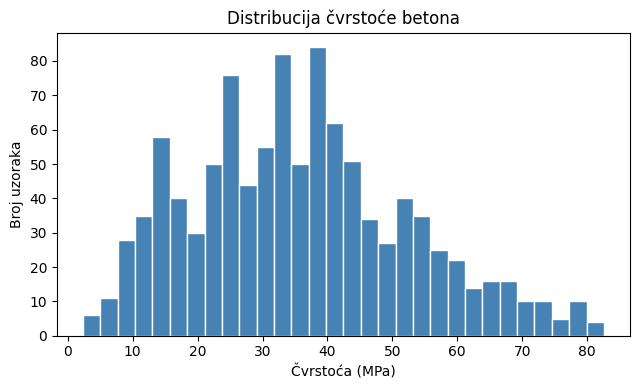

In [84]:
plot_strength_distribution(df_feat)

Čvrstoća je raspoređena u opsegu 2-82 MPa sa vrhom oko 25-40 MPa i blagom desnom asimetrijom.

### Odnos obeležja i čvrstoće

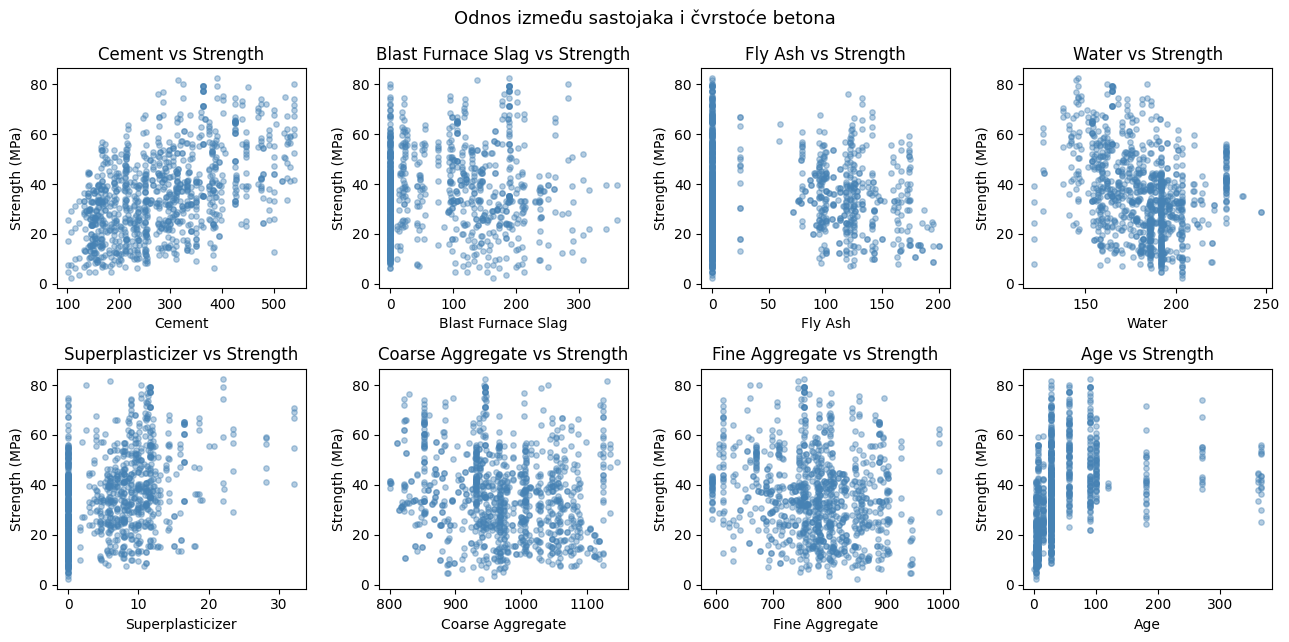

In [85]:
plot_scatter_vs_strength(df_feat)

Veze između obeležja i čvrstoće su pretežno **nelinearne**. Uočavaju se nule kod Blast Furnace Slag, Fly Ash i Superplasticizer - opcioni dodaci koji nisu prisutni u svakoj mešavini, što za modele nije problem.

### Uticaj starosti betona na čvrstoću

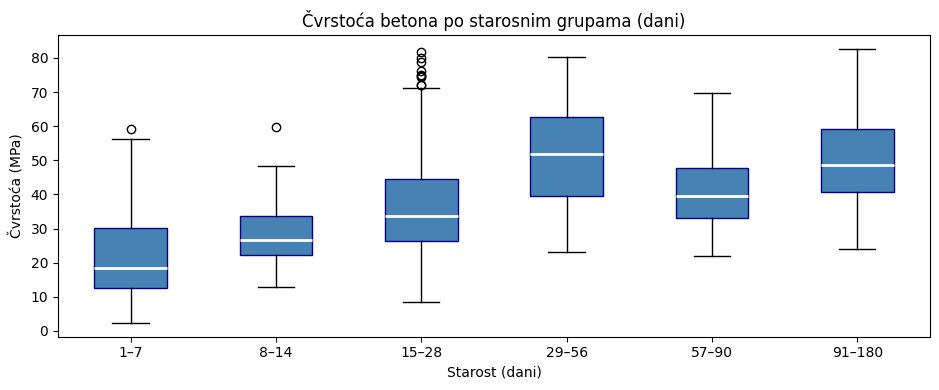

In [86]:
plot_age_vs_strength(df_feat)

Stariji beton je generalno čvršći- Age je jedan od najvažnijih prediktora. Posebno je važno primetiti da veza **nije linearna**: čvrstoća raste ubrzano do ~28 dana (standardni period negovanja betona), a zatim usporava i stabilizuje se. Ovakav nelinearni obrazac direktno ohrabruje primenu modela koji mogu da ga uhvate- Random Forest i XGBoost, za razliku od OLS-a koji pretpostavlja linearnu vezu.

### Korelaciona matrica

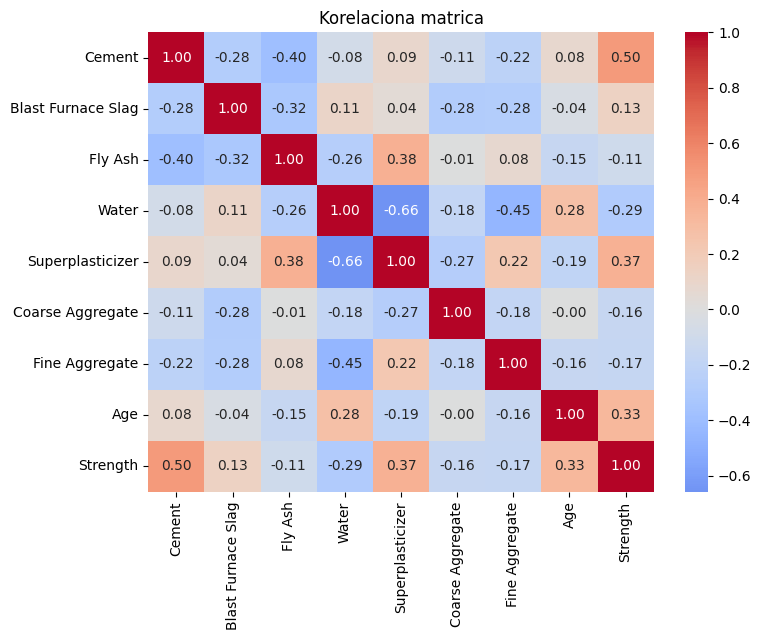

In [87]:
plot_correlation_heatmap(df_feat)

Cement (0.50) i Age (0.33) imaju najveću pozitivnu korelaciju sa čvrstoćom. Water ima negativnu korelaciju (-0.29) - u skladu sa Abrams-ovim zakonom (više vode -> manja čvrstoća).

Uočava se i **kolinearnost između prediktora** - npr. Blast Furnace Slag i Fly Ash su negativno korelisani sa Cement-om, što ima smisla jer se koriste kao delimična zamena za cement u mešavini. Ipak, **nijednu promenljivu ne možemo izbaciti**: sve su fizički sastojci betonske mešavine i svaka direktno utiče na njenu strukturu. Izbacivanje bilo koje od njih ne bi imalo smisla ni sa stanovišta domenskog znanja.

### Box plotovi obeležja (pre obrade)

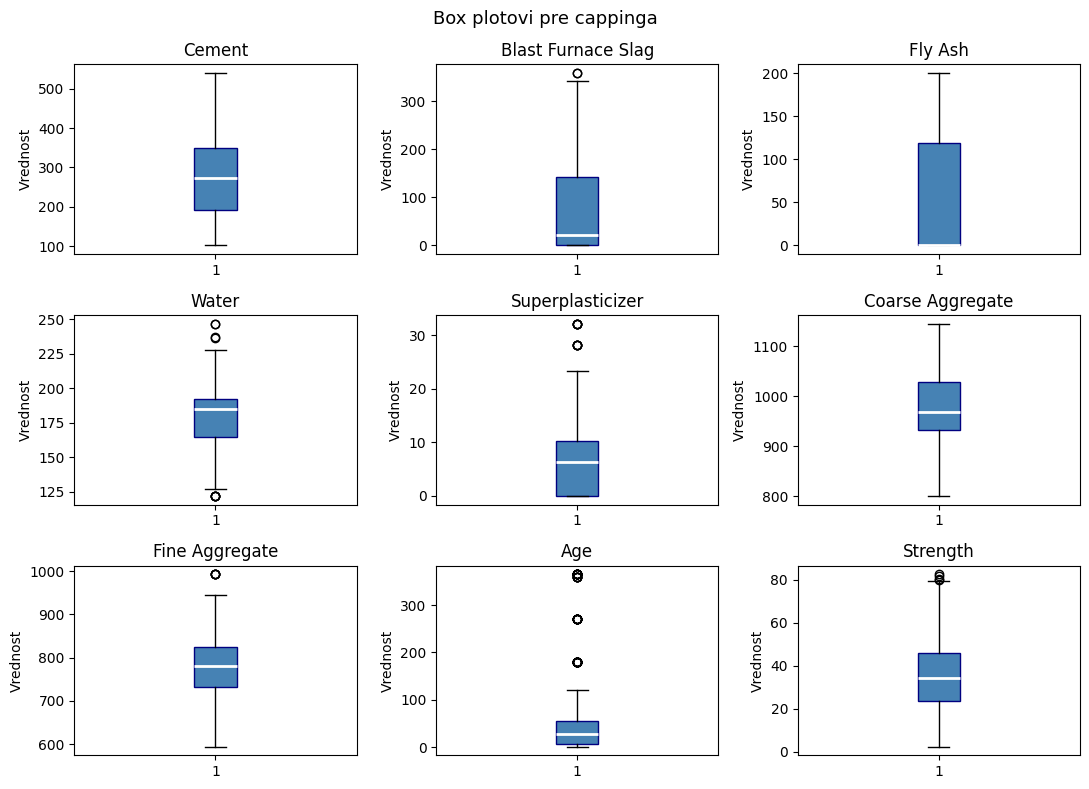

In [88]:
plot_boxplots(df_feat)

Uočavaju se outlieri, posebno kod Superplasticizer i Blast Furnace Slag -> motivisaće capping u narednom koraku preprocessinga radi poboljšanja OLS modela.

## Preprocessing

### Dodavanje feature-a: water_cement_ratio

In [89]:
df_feat[['Water', 'Cement', 'water_cement_ratio']].head(10)

,Water,Cement,water_cement_ratio
0,162.0,540.0,0.300000
1,162.0,540.0,0.300000
2,228.0,332.5,0.685714
3,228.0,332.5,0.685714
4,192.0,198.6,0.966767
5,228.0,266.0,0.857143
6,228.0,380.0,0.600000
7,228.0,380.0,0.600000
8,228.0,266.0,0.857143
9,228.0,475.0,0.480000


Ovaj feature direktno kodira Abrams-ov zakon: vise vode u odnosu na cement daje manju čvrstoću. Dodavanjem ovog odnosa dajemo modelu eksplicitan signal koji je fizički motivisan, umesto da ga model mora sam da izvede iz zasebnih kolona Water i Cement.

### Capping outliera

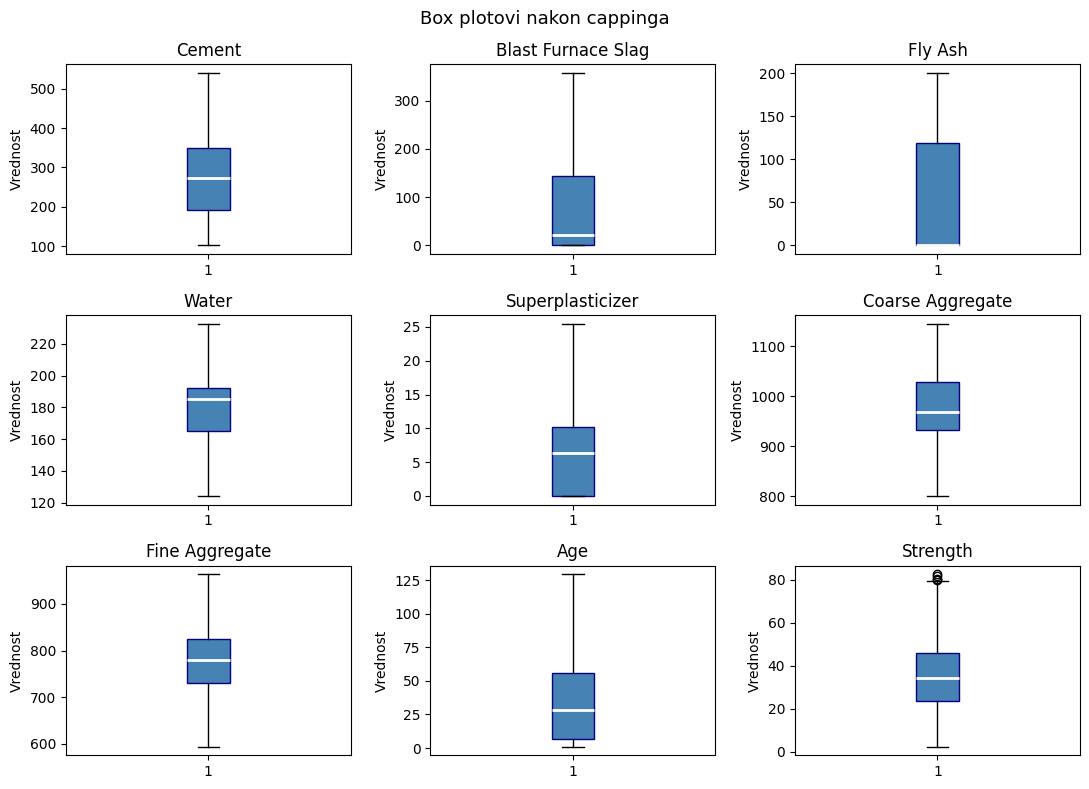

In [90]:
df_capped, _ = cap_outliers(df_feat)
plot_boxplots_after(df_capped)

Capping klipuje vrednosti van [Q1 - 1.5*IQR, Q3 + 1.5*IQR] za svih 8 obeležja. Primenjujemo ga samo za OLS - RF i XGBoost nisu osetljivi na outliere jer stabla dele prostor po granicama, a ne po vrednostima.

### Podela podataka (train / validacija / test)

In [91]:
# Split first, then cap using only train bounds (no data leakage)
x_train_u, x_val_u, x_test_u, y_train_u, y_val_u, y_test_u = split_data(df_feat)
x_train, cap_bounds = cap_outliers(x_train_u)
x_val, _ = cap_outliers(x_val_u, cap_bounds)
x_test, _ = cap_outliers(x_test_u, cap_bounds)
y_train, y_val, y_test = y_train_u, y_val_u, y_test_u

print(f"Train:      {len(x_train)} uzoraka ({len(x_train)/len(df_feat)*100:.0f}%)")
print(f"Validacija: {len(x_val)} uzoraka ({len(x_val)/len(df_feat)*100:.0f}%)")
print(f"Test:       {len(x_test)} uzoraka ({len(x_test)/len(df_feat)*100:.0f}%)")

Train:      618 uzoraka (60%)
Validacija: 206 uzoraka (20%)
Test:       206 uzoraka (20%)


Podela je urađena na 60% train, 20% validacija, 20% test, sa random_state=42 za reproduktivnost. Validacioni skup koristimo za podešavanje hiperparametara, a test skup samo za finalnu procenu modela.

## OLS linearna regresija

### Capped vs Uncapped poređenje (validacioni skup)

In [92]:
ols_capped = train_ols(x_train, y_train)
ols_uncapped = train_ols(x_train_u, y_train_u)

res_capped   = evaluate_model(ols_capped,   x_train,   x_val,   x_test,   y_train,   y_val,   y_test)
res_uncapped = evaluate_model(ols_uncapped, x_train_u, x_val_u, x_test_u, y_train_u, y_val_u, y_test_u)

pd.DataFrame({
    "Capped (OLS)":   res_capped["val"],
    "Uncapped (OLS)": res_uncapped["val"],
})

,Capped (OLS),Uncapped (OLS)
RMSE,8.87,10.66
MAE,6.91,8.47
MAPE,24.11,32.18


Capping poboljšava OLS metriku na validacionom skupu jer smanjuje uticaj ekstremnih vrednosti na procenu parametara. Koristimo validacioni skup za ovu odluku jer je test skup rezervisan isključivo za finalnu evaluaciju. RF i XGBoost treniramo na uncapped podacima jer stabla nisu osetljiva na outliere.

### Ablaciona analiza

Da li su svi feature-i zaista potrebni OLS modelu? **Backward elimination** postepeno uklanja feature-e u svakom koraku se izbacuje onaj čije uklanjanje najmanje povećava (ili najviše smanjuje) validation RMSE. Rezultat je pregled kako se performanse menjaju sa brojem feature-a.

In [93]:
ablation_results = ols_ablation(x_train, x_val, y_train, y_val)

df_abl = pd.DataFrame(ablation_results)[["step", "n_features", "removed", "train_rmse", "val_rmse"]]
df_abl.columns = ["Korak", "Br. feat.", "Uklonjen", "Train RMSE", "Val RMSE"]
df_abl

,Korak,Br. feat.,Uklonjen,Train RMSE,Val RMSE
0,0,9,None,8.24,8.87
1,1,8,Superplasticizer,8.36,8.73
2,2,7,Fine Aggregate,8.36,8.71
3,3,6,Coarse Aggregate,8.40,8.63
4,4,5,water_cement_ratio,8.43,8.65
5,5,4,Fly Ash,9.06,9.47
6,6,3,Blast Furnace Slag,10.84,11.27
7,7,2,Water,12.17,12.64
8,8,1,Age,14.42,14.86


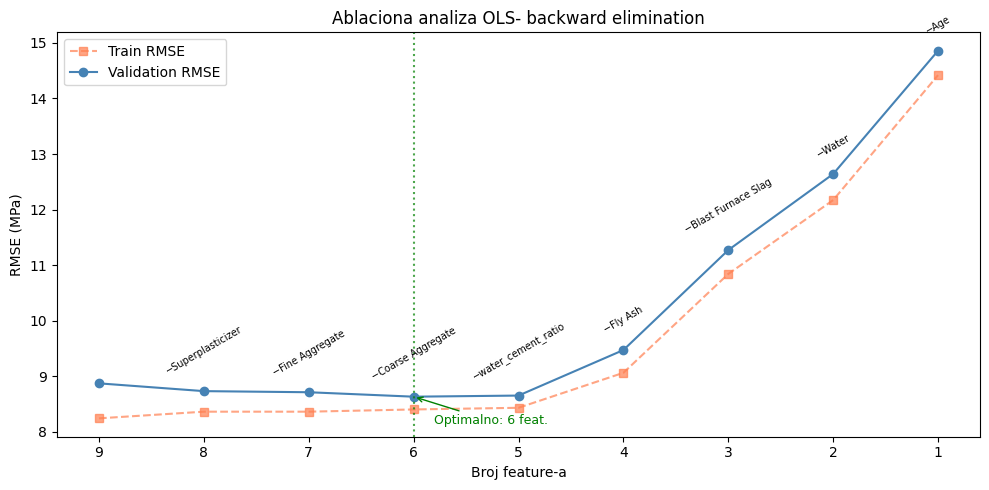

In [94]:
plot_ablation(ablation_results)

Ablaciona analiza otkriva da pun model sa 9 feature-a **nije optimalan**. Backward elimination pokazuje da uklanjanje Superplasticizer-a, Fine Aggregate-a i Coarse Aggregate-a poboljšava val RMSE sa 8.87 na 8.63 MPa. Ova tri feature-a su šum za linearni model- njihov doprinos je zanemarljiv ili negativan.

Stoga **retreniramo OLS sa 6 optimalnih feature-a** u nastavku. RF i XGBoost zadržavaju svih 9 jer stabla koriste i slabije feature-e efektivnije.

### Treniranje i evaluacija OLS sa optimalnim feature-ima

Ablacija je pokazala da je 6 feature-a optimalno za OLS. Retreniramo model sa redukovanim skupom feature-a.

In [95]:
# Optimalni feature-i prema ablaciji (korak sa min val RMSE)
best_step = min(ablation_results, key=lambda r: r["val_rmse"])
ols_features = best_step["features"]
print(f"Optimalni feature-i ({len(ols_features)}):", ols_features)

# Retreniranje OLS-a sa redukovanim skupom
ols = train_ols(x_train[ols_features], y_train)
results_ols = evaluate_model(ols, x_train[ols_features], x_val[ols_features], x_test[ols_features], y_train, y_val, y_test)
pd.DataFrame(results_ols).T

Optimalni feature-i (6): ['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 'Age', 'water_cement_ratio']


,RMSE,MAE,MAPE
train,8.40,6.54,24.00
val,8.63,6.73,23.40
test,9.04,6.97,23.86


Retreniran OLS sa 6 feature-a poboljšava val RMSE sa 8.87 na 8.63 MPa (test: 9.28 → 9.04). Uklanjanje šumnih feature-a smanjuje varijansu modela bez gubitka informacije. Ovaj model koristimo kao finalni OLS za poređenje.

### Dijagnostika modela

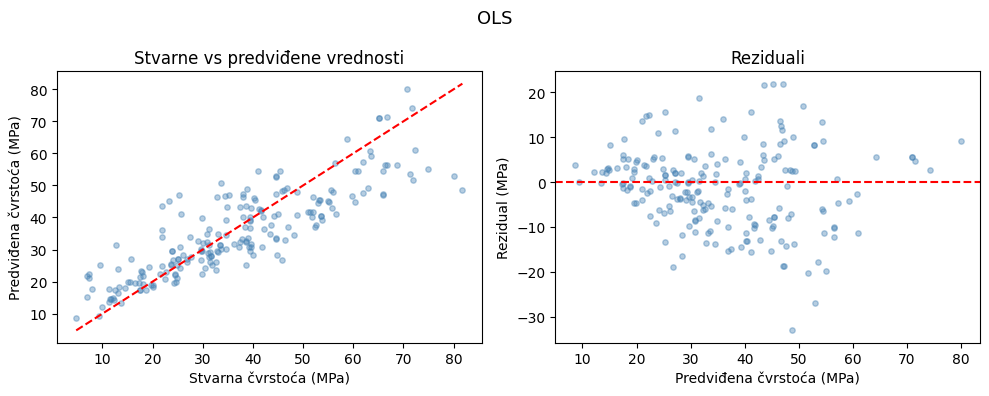

In [96]:
plot_single_model_diagnostics("OLS", ols, x_test[ols_features], y_test)

Na dijagnostičkom plotu vidimo sistematično odstupanje od dijagonale - model potcenjuje visoke vrednosti čvrstoće i precenjuje niske. Reziduali pokazuju sistematičan obrazac zavisnosti od predviđenih vrednosti, što ukazuje na nelinearnost u podacima koju linearni model ne može da uhvati.

### Provera pretpostavki OLS modela

In [97]:
validate_ols(x_train[ols_features], y_train)

PROVERA PRETPOSTAVKI OLS MODELA
  Linearnost (F-test)       : p = 5.5576e-173 -> OK  linearna veza
  Nezavisnost gresaka (DW)  : d = 1.904     -> OK  nema autokorelacije
  Normalnost reziduala (AD) : p = 0.0466   -> X nije normalna raspodela
  Homoskedasticnost (GQ)    : p = 0.5011   -> OK  jednaka varijansa
  Multikolinearnost         :             -> OK  nema savrsene kolinearnosti
---------------------------------------------------------
  Model validan: NE -- neke pretpostavke nisu ispunjene


False

Od 5 pretpostavki, 4 su ispunjene. Jedina koja pada je **normalnost reziduala** (Anderson-Darling p=0.0466, granično ispod praga 0.05). Nenormalnost reziduala ne znači nužno nelinearnost- može biti posledica asimetrične distribucije ciljne promenljive ili prisustva outliera. Ipak, nelinearnost veza u podacima (vidljiva u EDA i dijagnostici reziduala) strukturno ograničava OLS, što motiviše prelaz na nelinearne modele u nastavku.

## Random Forest

Random Forest gradi veliki broj stabala odlučivanja na nasumičnim podskupovima podataka i feature-a, a finalnu predikciju dobija usrednjavanjem svih stabala. Ovaj pristup smanjuje varijansu i povećava robustnost u poređenju sa pojedinačnim stablom.

Tuning modela radimo uz pomoć GridSearchCV koji pretražuje sve kombinacije zadatih hiperparametara i bira onu koja daje najmanji RMSE na 5-fold unakrsnoj validaciji. Za RF su pretraživani: broj stabala (`n_estimators`), maksimalna dubina stabla (`max_depth`), minimalni broj uzoraka u listu (`min_samples_leaf`) i udeo feature-a koji se razmatra pri svakoj podeli (`max_features`).

In [98]:
rf = tune_rf(x_train_u, y_train_u)
results_rf = evaluate_model(rf, x_train_u, x_val_u, x_test_u, y_train_u, y_val_u, y_test_u)
pd.DataFrame(results_rf).T

RF best params: {'max_depth': 15, 'max_features': 0.75, 'min_samples_leaf': 1, 'n_estimators': 300}


,RMSE,MAE,MAPE
train,2.07,1.38,4.84
val,4.79,3.64,13.06
test,6.17,4.26,14.26


RF postiže RMSE od ~6.17 MPa na test skupu - poboljšanje od ~34% u odnosu na OLS. GridSearchCV je pronašao optimalne hiperparametre kroz 5-fold unakrsnu validaciju.

### Dijagnostika modela

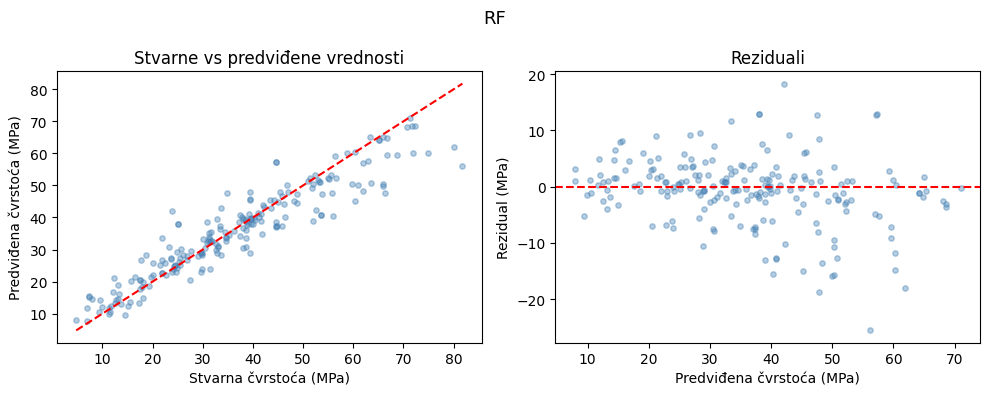

In [99]:
plot_single_model_diagnostics("RF", rf, x_test_u, y_test_u)

RF znatno bolje prati stvarne vrednosti od OLS-a. Reziduali su ravnomerniji oko nule, bez sistematskog obrasca koji je bio vidljiv kod OLS-a.

## XGBoost

XGBoost gradi stabla sekvencijalno - svako novo stablo ispravlja greške prethodnog (gradient boosting). Ugrađena regularizacija (L1 i L2) čini ga otpornim na overfitting i izuzetno efikasnim za strukturirane tabelarne podatke.

Isti GridSearchCV pristup kao kod RF, uz dodatne parametre specifične za XGBoost: brzina učenja (`learning_rate`), udeo uzoraka po stablu (`subsample`), udeo feature-a po stablu (`colsample_bytree`) i regularizacioni parametri (`reg_alpha`, `reg_lambda`) koji sprečavaju overfitting.

In [100]:
xgb = tune_xgb(x_train_u, y_train_u)
results_xgb = evaluate_model(xgb, x_train_u, x_val_u, x_test_u, y_train_u, y_val_u, y_test_u)
pd.DataFrame(results_xgb).T

XGB best params: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 0.8}


,RMSE,MAE,MAPE
train,2.35,1.65,5.74
val,4.14,3.03,10.46
test,5.49,3.71,11.73


XGBoost postiže RMSE od ~5.49 MPa - poboljšanje od ~39% u odnosu na OLS i ~11% u odnosu na RF. Model je treniran na uncapped podacima jer stabla nisu osetljiva na outliere.

### Dijagnostika modela

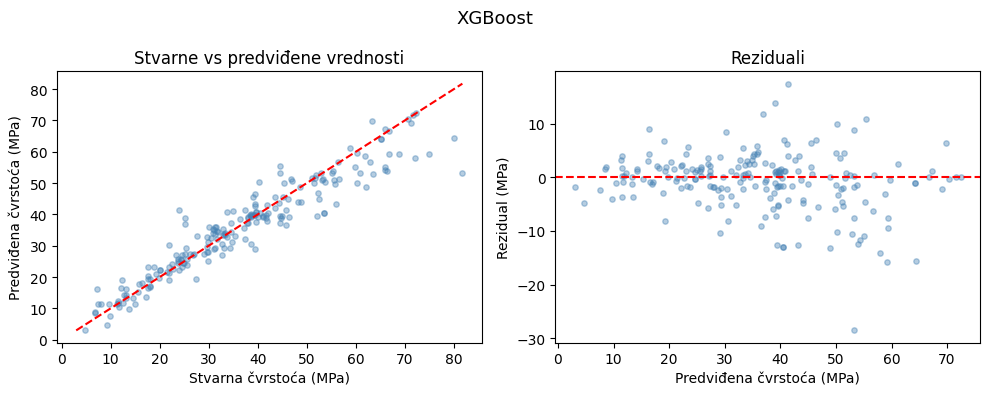

In [101]:
plot_single_model_diagnostics("XGBoost", xgb, x_test_u, y_test_u)

Reziduali su ravnomerno raspoređeni oko nule bez sistematskog obrasca - XGBoost uspešno hvata nelinearne veze koje su OLS-u izmicale.

### Feature importance (Q1)

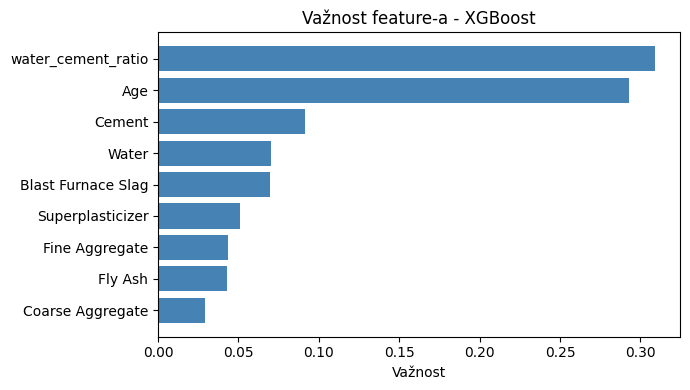

In [102]:
plot_feature_importance_single(xgb, "XGBoost")

**Q1 odgovor:** Age i water_cement_ratio su ubedljivo najvažniji prediktori čvrstoće betona. Age odražava proces hidratacije cementa, a water_cement_ratio direktno kodira Abrams-ov zakon. Cement dolazi na treće mesto.

## Poređenje modela (Q2)

Metrike sva tri modela na test skupu.

In [103]:
results_all = {"OLS": results_ols, "RF": results_rf, "XGBoost": results_xgb}
df_cmp = comparison_table(results_all)
df_cmp[df_cmp["Split"] == "test"].set_index("Model").drop(columns="Split")

,RMSE,MAE,MAPE
Model,,,
OLS,9.04,6.97,23.86
RF,6.17,4.26,14.26
XGBoost,5.49,3.71,11.73


**Q2 odgovor:** XGBoost je za 39% bolji od OLS-a po RMSE na test skupu (5.49 vs 9.04 MPa). Linearna regresija nije dovoljna - nelinearnost veza u podacima (vidljiva u EDA, potvrđena dijagnostikom reziduala) strukturno ograničava OLS.

## Q3 - Optimalni sastav i starost betona

Generišemo 50.000 nasumičnih kombinacija sastojaka unutar realnih granica trening skupa, predviđamo čvrstoću XGBoost modelom i prikazujemo top 10.

In [104]:
np.random.seed(42)
n = 50_000

base_cols = ["Cement", "Blast Furnace Slag", "Fly Ash", "Water",
             "Superplasticizer", "Coarse Aggregate", "Fine Aggregate", "Age"]

bounds = {col: (x_train_u[col].min(), x_train_u[col].max()) for col in base_cols}

samples = pd.DataFrame({col: np.random.uniform(lo, hi, n)
                        for col, (lo, hi) in bounds.items()})
samples["water_cement_ratio"] = samples["Water"] / samples["Cement"]
samples["Strength_predicted"] = xgb.predict(samples[x_train_u.columns])

samples.sort_values("Strength_predicted", ascending=False).head(10).reset_index(drop=True)

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,water_cement_ratio,Strength_predicted
0,406.690650,318.603674,49.090327,153.885548,10.534406,965.222532,629.866740,278.902575,0.378385,93.042076
1,377.157316,308.904788,61.201334,143.209572,7.777091,831.297070,633.100401,220.640898,0.379708,92.448250
2,468.098956,318.020948,3.092654,181.252923,10.650874,1027.424607,752.819933,157.890524,0.387211,92.038918
3,465.681120,301.496377,30.036480,179.071946,30.620395,824.792089,638.681382,259.350376,0.384538,91.854660
4,348.932913,288.840855,21.872253,142.519883,9.482238,827.478669,639.835545,354.262003,0.408445,91.036446
5,349.987143,335.613923,4.754940,133.736671,22.507905,823.492923,728.514048,351.441887,0.382119,90.999969
6,363.622822,284.039949,64.361745,136.387093,22.862167,985.047033,658.125991,233.777265,0.375078,90.966324
7,468.494893,326.794560,32.603515,137.970583,11.482924,1013.935604,680.652026,104.823813,0.294498,90.898422
8,360.720532,315.599927,60.219363,133.973427,31.021013,856.530610,618.226040,279.901953,0.371405,90.781158
9,334.286883,316.310139,24.280246,150.793224,11.378541,841.664608,679.590838,118.217217,0.451089,90.760078


Model konzistentno prepoznaje iste obrasce: maksimalna čvrstoća se postiže sa visokim sadržajem cementa, niskim water_cement_ratio i starošću od 200+ dana. Predviđene vrednosti (~90-93 MPa) prelaze maksimum trening skupa (82.6 MPa), što znači da model ekstrapolira - rezultate treba tumačiti kao smernice za optimizaciju, ne kao garantovane vrednosti.

## Zaključak

- **Q1** - Najvažniji prediktori čvrstoće su Age i water_cement_ratio, zatim Cement. Ovo je u potpunosti u skladu sa Abrams-ovim zakonom i fizikom procesa hidratacije.
- **Q2** - Linearna regresija nije dovoljna. XGBoost postiže RMSE od 5.49 MPa, što je poboljšanje od 39% u odnosu na OLS (9.04 MPa). Nelinearnost veza čini OLS strukturno neadekvatnim za ovaj problem.
- **Q3** - Najveću predviđenu čvrstoću postižu mešavine sa visokim sadržajem cementa, niskim water_cement_ratio i starošću od 200+ dana.